<a href="https://colab.research.google.com/github/saish23/Deep-Learning-Projects-/blob/main/Mask_Detection_CV_Model%20using%20YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d andrewmvd/face-mask-detection

100% 396M/398M [00:02<00:00, 150MB/s]
100% 398M/398M [00:02<00:00, 167MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile('/content/face-mask-detection.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

In [6]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 15.1 MB/s eta 0:00:00


In [7]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.133 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.0/78.2 GB disk)


In [8]:
directory = "/content/"
image_directory = directory + "/images"
annotation_directory = directory + "/annotations"
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

In [9]:
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text

        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')

        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

filename      label  class_id  width  height              bboxes
0  maksssksksss488.png  with_mask         0    400     267  [188, 51, 211, 76]
1  maksssksksss488.png  with_mask         0    400     267    [41, 54, 64, 78]
2  maksssksksss680.png  with_mask         0    400     267   [28, 76, 44, 101]
3  maksssksksss680.png  with_mask         0    400     267  [159, 66, 176, 86]
4  maksssksksss680.png  with_mask         0    400     267  [174, 34, 186, 53]

In [10]:
df_data['label'].unique()

array(['with_mask', 'without_mask', 'mask_weared_incorrect'], dtype=object)

In [11]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


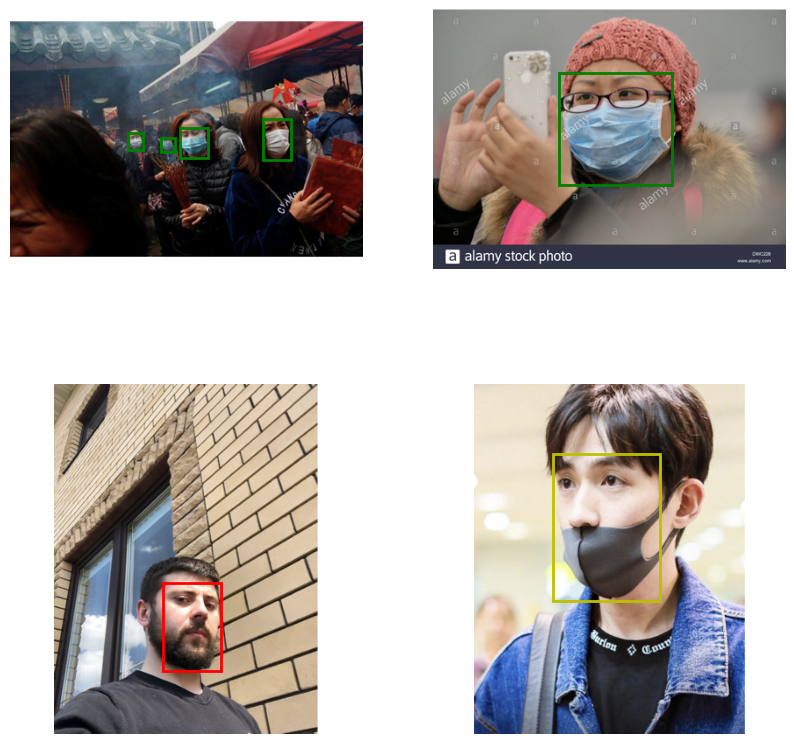

In [12]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]

        image = Image.open(image_directory + '/' + filename)

        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)

        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"

            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes

            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min,
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)

show_random_images_with_bbox(df_data)

In [13]:
# we need to convert our bbox format to yolo as the current one that we have is on pascal_voc
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array

    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h

    width = (x_max - x_min) / w
    height = (y_max - y_min) / h

    return [x_center, y_center, width, height]

In [14]:
train_path = "/content/datasets/train"
valid_path = "/content/datasets/valid"
test_path = "/content/datasets/test"

os.mkdir("/content/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [15]:
train, test = train_test_split(df_data.filename.unique(), test_size=0.2, random_state=23)
train, valid = train_test_split(train, test_size=0.15, random_state=23)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")


copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [16]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")

walk_through_dir(train_path)
walk_through_dir(valid_path)
walk_through_dir(test_path)

There are 0 directories and 579 images in '/content/datasets/train'.
There are 0 directories and 103 images in '/content/datasets/valid'.
There are 0 directories and 171 images in '/content/datasets/test'.


In [17]:
classes = list(df_data.label.unique())
class_count = len(classes)
facemask_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)

%cat facemask.yaml


    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

In [18]:
model = YOLO("yolov8n.pt")
model.train(data="facemask.yaml", epochs=50)

100%|██████████| 6.23M/6.23M [00:00<00:00, 118MB/s]
Ultralytics YOLOv8.0.133 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=Fa

In [19]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.0.133 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients
val: Scanning /content/datasets/valid.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]
                   all        103        643      0.921      0.745      0.833      0.549
             with_mask        103        517      0.965      0.853      0.928       0.62
 mask_weared_incorrect        103         17      0.868      0.647      0.695      0.478
          without_mask        103        109       0.93      0.734      0.875       0.55
Speed: 3.9ms preprocess, 24.7ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/val


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f5d0463fa30>
fitness: 0.5775127126480722
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.61979,     0.47772,     0.54988])
names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
plot: True
results_dict: {'metrics/precision(B)': 0.921260948834545, 'metrics/recall(B)': 0.7445446349330562, 'metrics/mAP50(B)': 0.8329494525200666, 'metrics/mAP50-95(B)': 0.5491308526622951, 'fitness': 0.5775127126480722}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 3.8830562702660423, 'inference': 24.70019025710023, 'loss': 0.0010231166209989382, 'postprocess': 6.502200098871027}

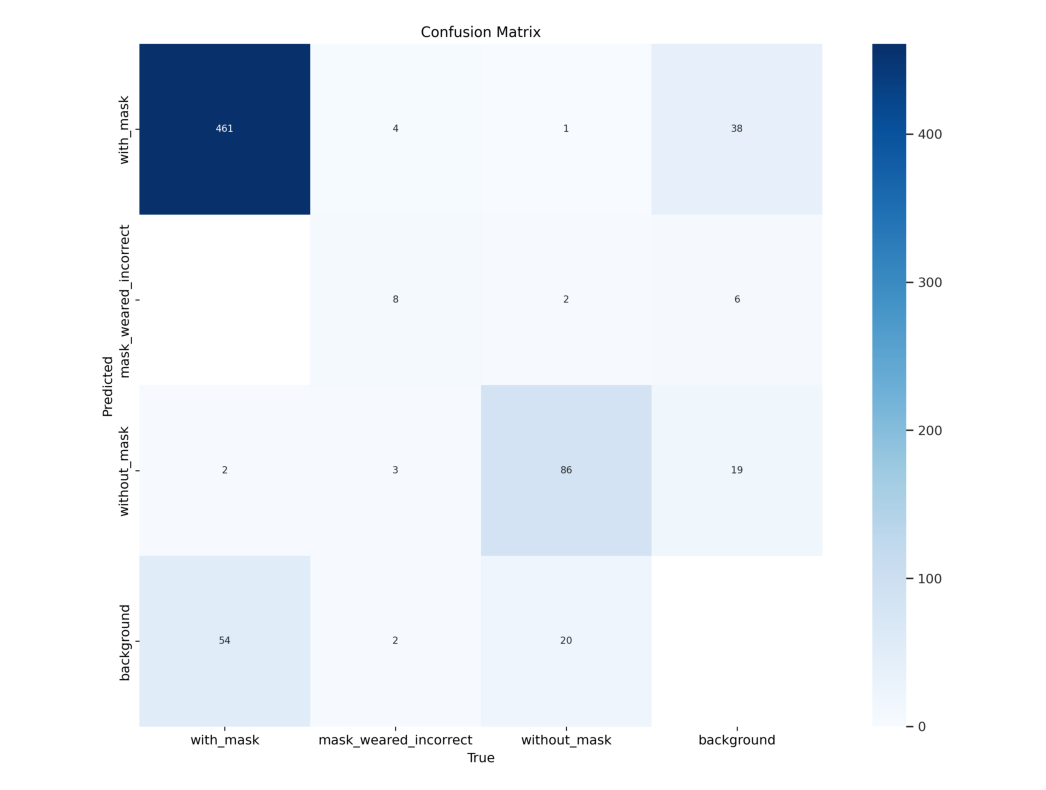

In [21]:
confusion_matrix = Image.open("/content/runs/detect/train/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

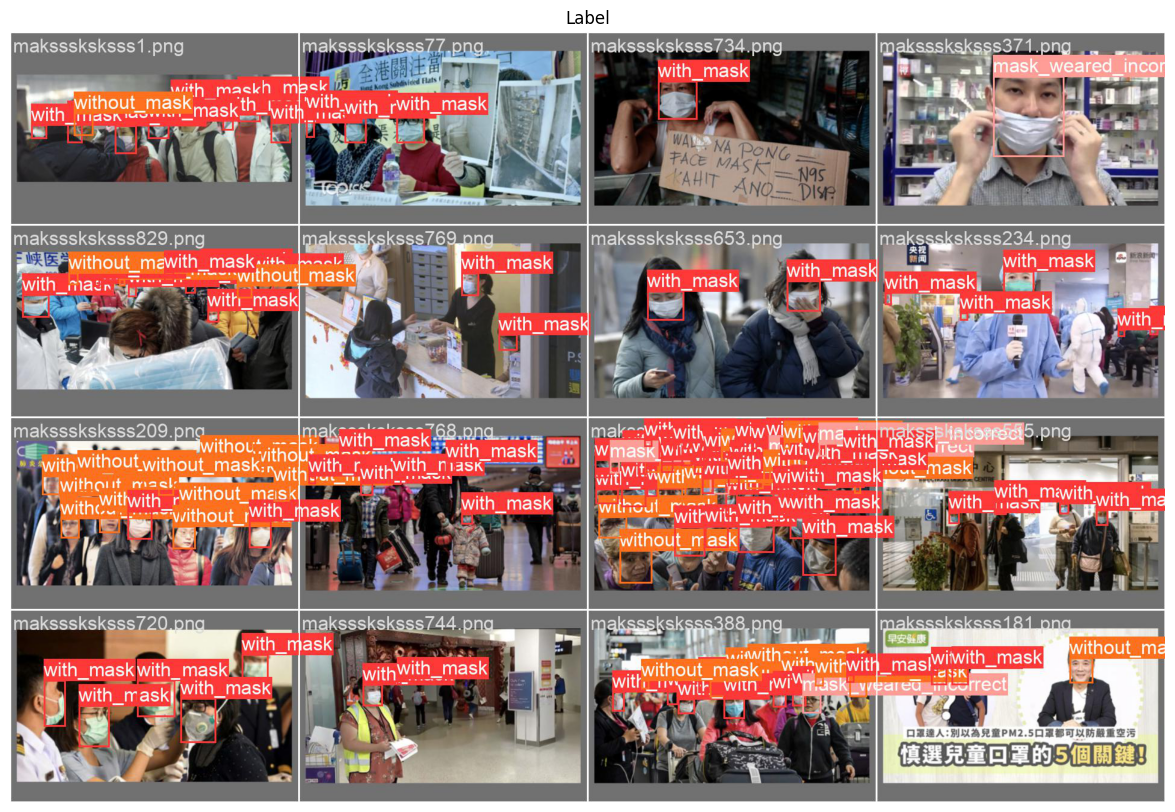

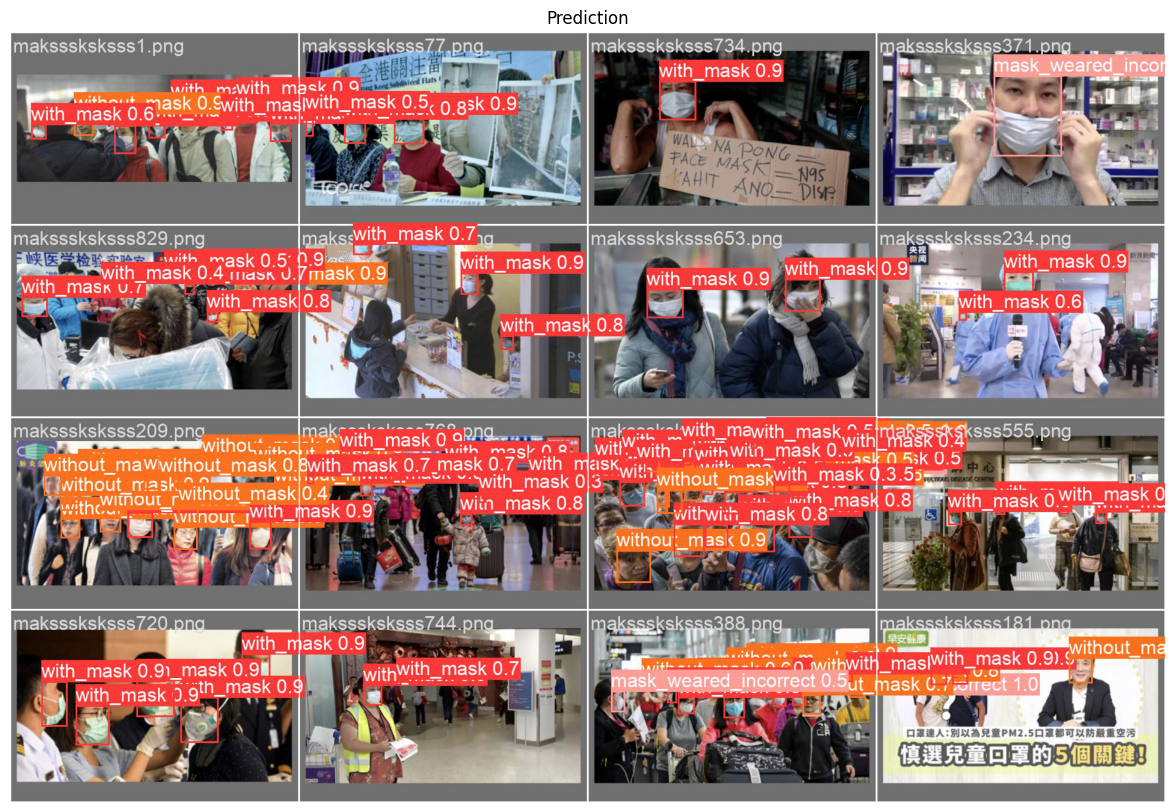

In [22]:
val_label = Image.open("/content/runs/detect/train/val_batch0_labels.jpg")
val_pred = Image.open("/content/runs/detect/train/val_batch0_pred.jpg")

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

In [24]:
model = YOLO(model="/content/runs/detect/train/weights/best.pt")

In [25]:
filenames = glob.glob(test_path+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2], save=True, line_thickness=1)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

0: 640x640 2 with_masks, 1: 640x640 1 with_mask, 63.7ms
Speed: 3.0ms preprocess, 31.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


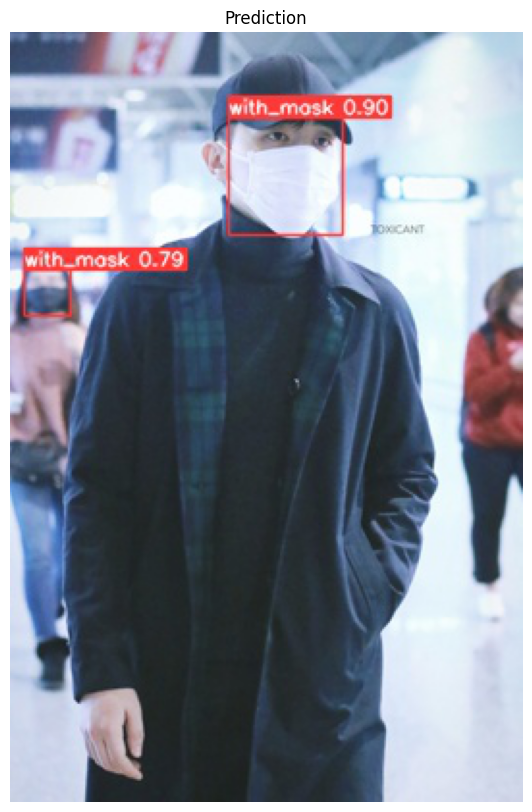

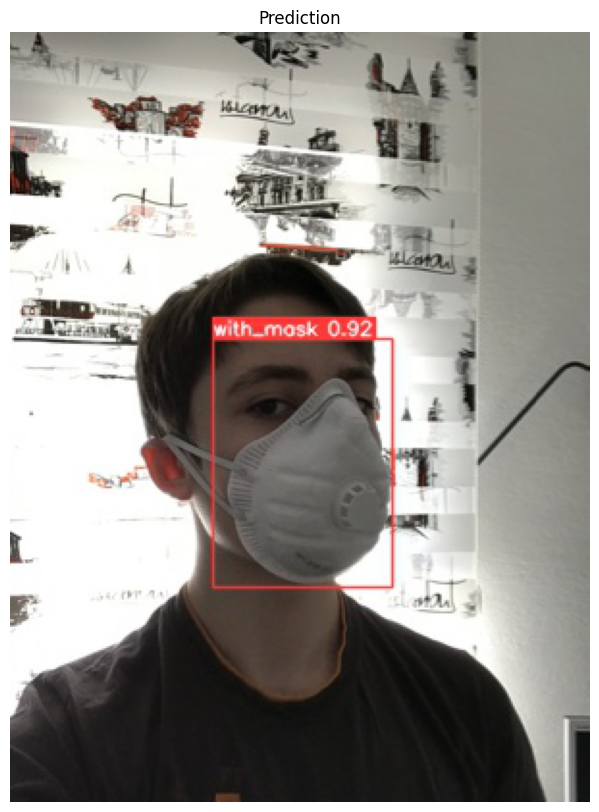

In [26]:
predicted_image = Image.open("runs/detect/predict/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/predict/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()